# Analysis of differential expression across conditions

In [1]:
import pandas as pd
import numpy as np
import os
import json
import copy
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import Dokdonia_code as Dc
%matplotlib inline

In [25]:
import pickle

def saveToPickleFile(python_object, path_to_file='object.pkl'):
    """
    Save python object to pickle file
    """
    out_file = open(path_to_file,'wb')
    pickle.dump(python_object, out_file)
    out_file.close()
    
def readFromPickleFile(path_to_file='object.pkl'):
    """
    Load python object from pickle file.
    Returns python object.
    """
    in_file = open(path_to_file,'rb')
    python_object = pickle.load(in_file)
    return python_object

In [2]:
# Parsing GBK file and KEGG pathways
with open('Data/Function_Annotations/kegg_pathways.json') as json_file:
    kegg_pathways = json.load(json_file)['children']
kegg_dict = Dc.assignSystemsToEnzymes(kegg_pathways)
    
gbk = Dc.GenomeGBK('Data/DokdoniaMED134.gbk')
gbk.meta

{'organism': ['Dokdonia sp. MED134'],
 'mol_type': ['genomic DNA'],
 'strain': ['MED134'],
 'isolation_source': ['collected at a depth of 1 meter; isolated by plating on solid media'],
 'db_xref': ['taxon:313590'],
 'country': ['Mediterranean Sea']}

In [3]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('Data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


## Analysis of differential expression

We compare expression across temperature and between light and dark conditions.

## DE light vs dark across temperatures

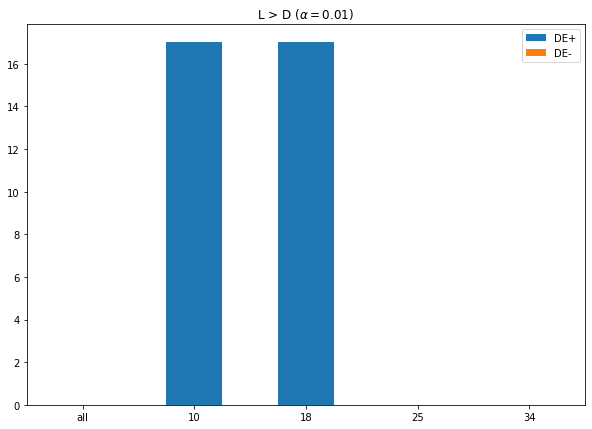

In [4]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = Dc.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = Dc.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L > D ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [5]:
L_D_stats

{'all': {'DE+': 0, 'DE-': 0},
 '10': {'DE+': 17, 'DE-': 0},
 '18': {'DE+': 17, 'DE-': 0},
 '25': {'DE+': 0, 'DE-': 0},
 '34': {'DE+': 0, 'DE-': 0}}

In [6]:
# L > D, T = 18 Proteins
res = L_D_res['18']
np.unique([gbk.getGeneInfo(gene_id)['product'][0] for gene_id in res[res.log2FoldChange > 0.5].index])

array(['ABC1 family protein', 'ATP-dependent protease La (LON)',
       'DNA photolyase/cryptochrome, animal cryptochrome and (6-4) photolyase subfamily',
       'GTP cyclohydrolase I', 'cryptochrome, DASH family',
       'deoxyribodipyrimidine photolyase-related protein',
       'hypothetical protein', 'peptide-methionine (S)-S-oxide reductase',
       'phytoene dehydrogenase', 'putative cell adhesion protein',
       'rhodopsin', 'sensor of blue-light using FAD',
       'short chain dehydrogenase'], dtype='<U79')

## DE genes are related to light...

__1. Light-induced DNA repair__:
* DNA photolyase/cryptochrome
* Animal cryptochrome and (6-4) photolyase subfamily
* Cryptochrome, DASH family
* Deoxyribodipyrimidine photolyase-related protein

__2. Rhodpsin and retinal-related genes__:
* Rhodopsin
* Phytoene dehydrogenase (retinal biosynthesis)
* Sensor of blue-light using FA

__3. Transporters__:
* ABC1 family protein (actually apparently chaperonins: http://pfam.xfam.org/family/abc1)

__4. Others__:
* GTP cyclohydrolase I
* Short chain dehydrogenase
* Putative cell adhesion protein
* ATP-dependent protease La (LON)
* Peptide-methionine (S)-S-oxide reductase

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

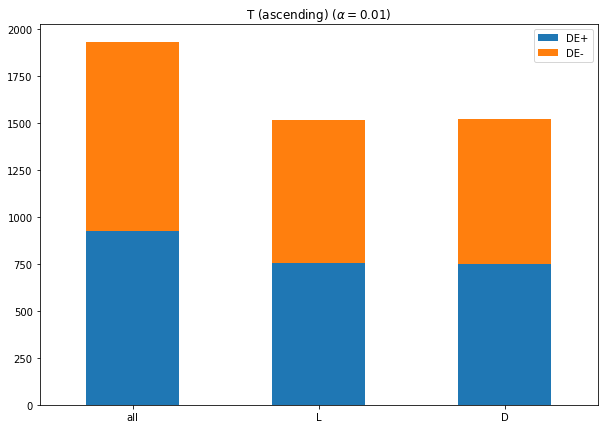

In [7]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = Dc.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = Dc.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')
    
# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

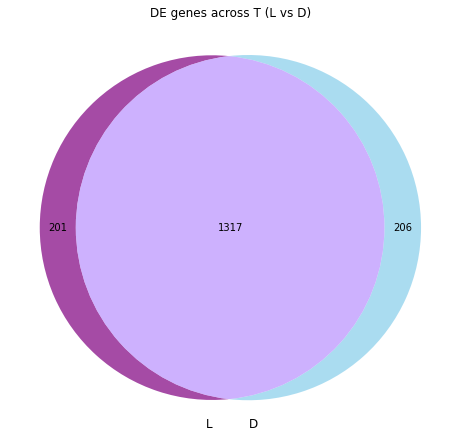

In [8]:
# Plot L-D Venn diagram
plt.figure(figsize=(8, 8))
set1 = set(T_res['L'].index)
set2 = set(T_res['D'].index)
Light_specific_DE_genes = set1 - set2
Dark_specific_DE_genes = set2 - set1
venn2([set1, set2], ('L', 'D'),
      set_colors=('purple', 'skyblue'), alpha = 0.7)
plt.title('DE genes across T (L vs D)')
plt.show()

## Which pathways are represented in across-temperature-DE genes specific of light and dark conditions?

In [9]:
light_DE = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
            for gene_id in Light_specific_DE_genes if gbk.has_EC_number(gene_id)]
dark_DE = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
            for gene_id in Dark_specific_DE_genes if gbk.has_EC_number(gene_id)]

In [10]:
# Dark-specific genes which are DE across temperatures
Dc.getCounts([kegg_dict[ec]['system'] for ec, name in dark_DE if ec in kegg_dict.keys()])

{'09101 Carbohydrate metabolism': 10,
 '09105 Amino acid metabolism': 7,
 '09108 Metabolism of cofactors and vitamins': 5,
 '09104 Nucleotide metabolism': 3,
 '09132 Signal transduction': 3,
 '09107 Glycan biosynthesis and metabolism': 2,
 '09191 Unclassified: metabolism': 2,
 '09106 Metabolism of other amino acids': 1,
 '09109 Metabolism of terpenoids and polyketides': 1,
 '09124 Replication and repair': 1,
 '09174 Infectious disease: parasitic': 1}

In [11]:
# Light-specific genes which are DE across temperatures
Dc.getCounts([kegg_dict[ec]['system'] for ec, name in light_DE if ec in kegg_dict.keys()])

{'09104 Nucleotide metabolism': 4,
 '09101 Carbohydrate metabolism': 3,
 '09132 Signal transduction': 3,
 '09103 Lipid metabolism': 2,
 '09106 Metabolism of other amino acids': 2,
 '09107 Glycan biosynthesis and metabolism': 2,
 '09108 Metabolism of cofactors and vitamins': 2,
 '09122 Translation': 2,
 '09124 Replication and repair': 2,
 '09105 Amino acid metabolism': 1,
 '09191 Unclassified: metabolism': 1}

## Gene clustering based on expression pattern
We will employ _clust_ to cluster significant DE genes into groups of similar expression pattern across conditions.

__CLUST__:

"Clust is designed to address this problem by extracting the largest and least dispersed set of clusters whose profiles are distinct and exclude those genes that do not belong to these clusters. That is, to identify and extract the complete set of genes that are exhibiting coordinate behavior in the experimental series under consideration."

# Cluster TPM values (with default Clust normalization for TPM values)

__NOTE__: Should check whether raw counts (normalized horizontally by max) follow expression patterns in clust's clusters. Then repeat with trancripts/cell. Could be a manner of assess the utility of transcrits/cell.

In [12]:
# Get TPM values
clust_data = pd.read_csv('Data/tpm_counts.csv', index_col=0)
clust_data = clust_data[clust_data.filter(regex='^[^T]+$').columns]
clust_data.index.name = 'ID'
clust_data.columns = conditions

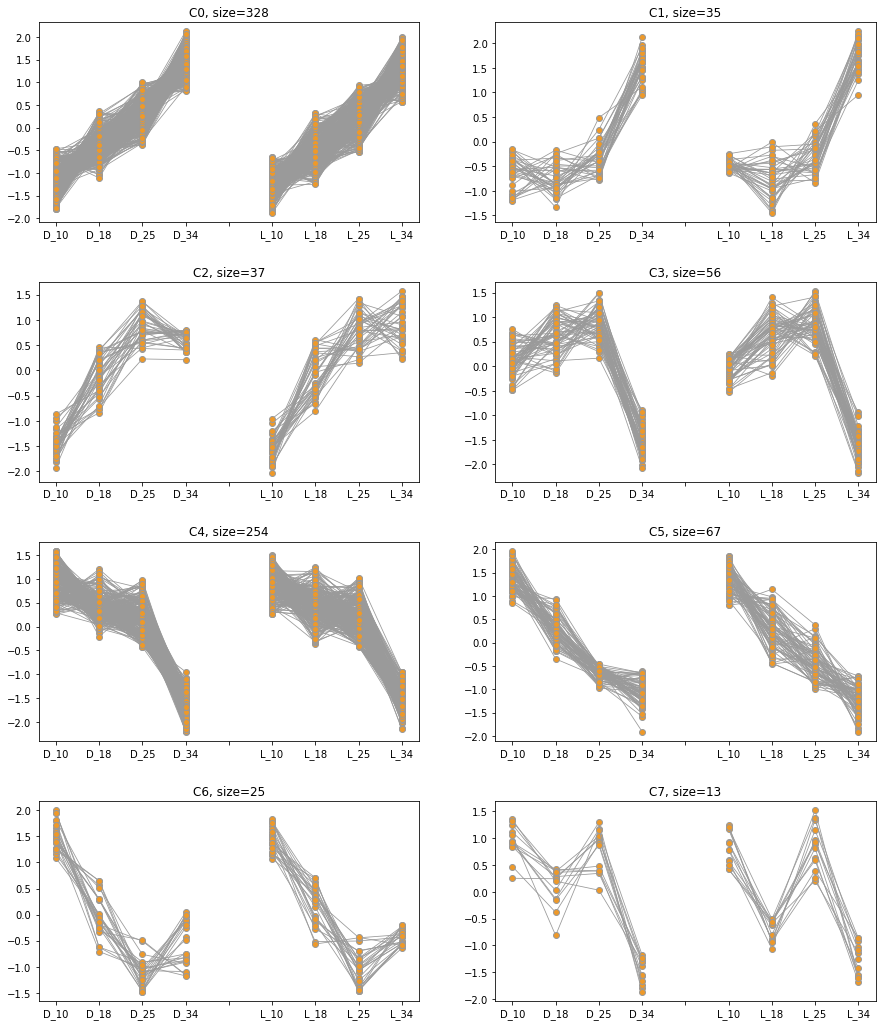

In [13]:
# Cluster only DE genes across temperatures (n_counts)
res_id = 'CLUSTER_DE_GENES'
gene_ids = T_res['all'].index
workdir = os.path.join(os.getcwd(),'Results')
DE_Data = clust_data[clust_data.index.isin(gene_ids)]
clusters = Dc.getGeneClusters(DE_Data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=5)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

# Obtain DE genes without cluster
genes_in_cluster = [gene for gene_ids in clusters.values() for gene in gene_ids]
genes_without_cluster = np.setdiff1d(gene_ids, genes_in_cluster)

Dc.plotClusters(pdata, clusters)

In [14]:
print(f'There a total of {len(genes_in_cluster)} DE genes assigned to a cluster')
print(f'There a total of {len(genes_without_cluster)} DE genes not assigned to any cluster')

There a total of 815 DE genes assigned to a cluster
There a total of 1115 DE genes not assigned to any cluster


## DE genes not assigned to any cluster
Let's run cluster again using the subset of genes not assigned to any cluster.

There a total of 331 DE genes assigned to a cluster
There a total of 784 DE genes not assigned to any cluster


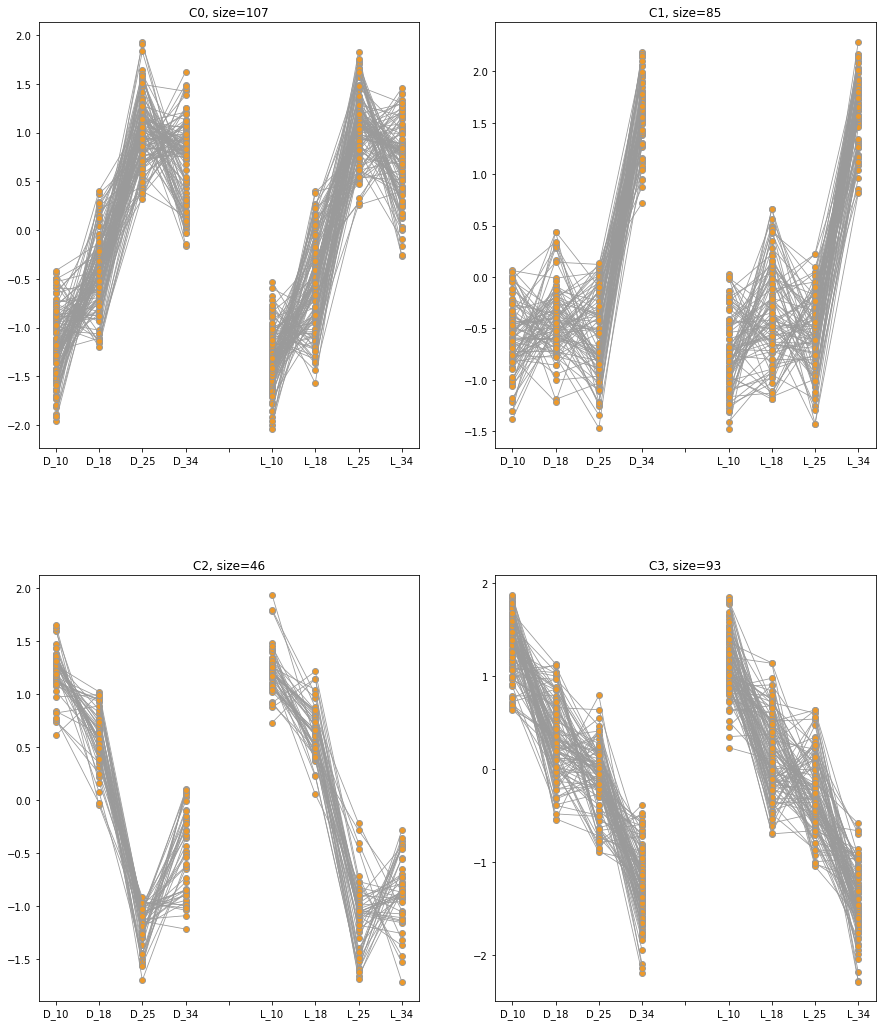

In [15]:
# Cluster only DE genes across temperatures (n_counts)
res_id = 'CLUSTER_DE_GENES_NOT_ASSIGNED'
gene_ids = genes_without_cluster
workdir = os.path.join(os.getcwd(),'Results')
DE_Data = clust_data[clust_data.index.isin(gene_ids)]
na_clusters = Dc.getGeneClusters(DE_Data, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=5)

pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

# Obtain DE genes without cluster
genes_in_cluster = [gene for gene_ids in na_clusters.values() for gene in gene_ids]
genes_without_cluster = np.setdiff1d(gene_ids, genes_in_cluster)

print(f'There a total of {len(genes_in_cluster)} DE genes assigned to a cluster')
print(f'There a total of {len(genes_without_cluster)} DE genes not assigned to any cluster')

Dc.plotClusters(pdata, na_clusters)

These clusters show patterns that are similar to the some of the first. Specifically, we could join C0 here with C2 in the first cluster set, C1 with C1, C2 with C6 and C3 with C5.

In [16]:
# Joined clusters
joined_clusters = copy.deepcopy(clusters)
joined_clusters['C2'].extend(na_clusters['C0'])
joined_clusters['C1'].extend(na_clusters['C1'])
joined_clusters['C6'].extend(na_clusters['C2'])
joined_clusters['C5'].extend(na_clusters['C3'])

## On clusters
Clusters are very similar between light and dark conditions, unlike Prochlorococcus. This makes sense, since Dokdonia is not photosynthetic. Also, the differences in DE genes between light and dark were minimal.

# Identifying pathways
Obtaining function annotations from KEGG

In [17]:
# Add EggNOG function data to genes (prepare fasta input file)
# Dc.getEggNOGInputFile('Data/DokdoniaMED134.gbk')
# Run EggNOG Mapper: http://eggnog-mapper.embl.de/ using input file

In [18]:
# Read eggNOG - Mapper (http://eggnog-mapper.embl.de/) results 
eggNOG = pd.read_excel('Data/Function_Annotations/result_eggnogMapper.xlsx', header=4)
eggNOG = eggNOG[eggNOG['best tax lvl'] == 'Dokdonia']
ko_pathway_dict = Dc.getKEGGPathwayDict(kegg_pathways)
gene_ko_dict= Dc.getGeneKOs(eggNOG)
eggNOG.head()

,Query,Seed ortholog,e-value,score,best tax lvl,Preferred_name,GO terms,EC number,KEGG KO,KEGG pathway,...,KEGG rclass,BRITE,KEGG TC,CAZy,BiGG reaction,annot lvl,matching OGs,Best OG,COG cat,description
0,MED134_07389,313590.MED134_07389,0.000000e+00,3110.5,Dokdonia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacteria,"1IJKA@117743,37FU7@326319,4NMB8@976,COG1361@1,...",NA|NA|NA,M,C-terminal domain of CHU protein family
1,MED134_07384,313590.MED134_07384,1.800000e-178,631.7,Dokdonia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacteria,"1HWKC@117743,37EMJ@326319,4NEVD@976,COG3064@1,...",NA|NA|NA,M,Type IX secretion system membrane protein PorP...
2,MED134_07379,313590.MED134_07379,0.000000e+00,1308.9,Dokdonia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacteria,"1HXNY@117743,37E57@326319,4NE6G@976,COG2885@1,...",NA|NA|NA,MU,WD40-like Beta Propeller Repeat
3,MED134_07374,313590.MED134_07374,2.500000e-97,361.3,Dokdonia,idi,"GO:0003674,GO:0003824,GO:0004452,GO:0005575,GO...","4.1.1.33,5.3.3.2","ko:K01597,ko:K01823","ko00900,ko01100,ko01110,ko01130,map00900,map01...",...,"RC00453,RC00455","ko00000,ko00001,ko00002,ko01000",NaN,NaN,NaN,Bacteria,"1HXIQ@117743,37ET7@326319,4NFJV@976,COG1443@1,...",NA|NA|NA,I,NUDIX domain
4,MED134_07369,313590.MED134_07369,3.400000e-73,280.8,Dokdonia,ygcM,NaN,"4.1.2.50,4.2.3.12",ko:K01737,"ko00790,ko01100,map00790,map01100",...,"RC01117,RC02846,RC02847","ko00000,ko00001,ko00002,ko01000,ko03016",NaN,NaN,NaN,Bacteria,"1I1ZF@117743,37F1A@326319,4NNIS@976,COG0720@1,...",NA|NA|NA,H,6-pyruvoyl tetrahydropterin synthase


In [20]:
# gene_list = []
# Dc.getKEGGpathwaysForGeneList(ko_pathway_dict, gene_ko_dict, gene_list)

In [21]:
# cluster_KEGG = Dc.getKEGGpathwaysForGeneList(ko_pathway_dict, gene_ko_dict, clusters['C2'])

# # Interactive plot of KEGG systems and subsystems  
# Dc.plotSystemsAndSubsystems(cluster_KEGG, ko_pathway_dict, color='#dd912d')

In [21]:
# Static interact plot
res_id = 'CLUSTER_DE_GENES'
pdata = pd.read_csv(os.path.join(
    os.getcwd(),f'Results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
                    sep='\t', index_col='Genes')
# Add fake column to separate datasets
pdata.insert(4, '', [np.nan for n in range(pdata.shape[0])])

Dc.plotSystemsAndSubsystemsWebPage(joined_clusters, pdata, ko_pathway_dict, gene_ko_dict, color='#dd912d')

# Notes about function annotation in clusters

I seem to get Carbohydrate and amino acid metabolism in the first places in a majority of clusters. Perhaps because these are the most common categories and not because they are particularly enriched in the clusters. Should normalize by category size (number of genes assigned to that category). I guess this is what an enrichment analysis does.

## Custom enrichment analysis via permutation

Randomly allocate genes from the DE group to fake clusters of same size as originals: Assign cluster to each index in a list, e.g. 0:300 -> cluster 0, then randomly draw a set of DE genes equal to the size of the sum of all clusters and assign cluster according to their indices. Or, permute DE genes and reassign to cluster. Consider an additional "cluster" composed of those genes unassigned to any cluster.

__NOTE__

Using pvalues as signal-to-noise indicators to rank pathways instead of hypothesis testing: https://www.researchgate.net/post/While_doing_GO_enrichment_analysis_what_to_choose_p_value_or_adjusted_p_value_and_why 

It doesn't matter if using corrected or uncorrected pvalues since the correction is a monotone function, the ranking would be the same.

__NOTE ABOUT eggNOG mapper__

eggNOG mapper result giving me wrong associations, e.g., ko00196 "Photosynthesis and Antenna" for gene MED134_06814 of Dokdonia! When the reported EC number is 1.8.1.2 involved in Sulphur metabolism.

Thinking of using the Biocyc database for pathways if allowed.

In [29]:
# Trying this out         
gene_list = np.array(T_res['all'].index) 

p_KEGG_paths = Dc.runClusterPathwayEnrichmentAnalysis(
    gene_list, joined_clusters, ko_pathway_dict, gene_ko_dict, n_permutations=100000)

# saveToPickleFile(p_KEGG_paths, path_to_file='p_KEGG_paths.pkl')
# p_KEGG_paths = readFromPickleFile(path_to_file='p_KEGG_paths.pkl')

In [35]:
gene_ko_dict['MED134_06814']

['ko00196', 'ko00920', 'ko01100', 'ko01120']

In [38]:
[ko_pathway_dict[ko] for ko in gene_ko_dict['MED134_06814'] if ko in ko_pathway_dict.keys()]

[{'subsystem': '00196 Photosynthesis - antenna proteins [PATH:ko00196]',
  'system': '09102 Energy metabolism',
  'supersystem': '09100 Metabolism'},
 {'subsystem': '00920 Sulfur metabolism [PATH:ko00920]',
  'system': '09102 Energy metabolism',
  'supersystem': '09100 Metabolism'}]

In [33]:
p_KEGG_paths['C2']['subsystem']

{'00521 Streptomycin biosynthesis [PATH:ko00521]': (0.031578947368421054,
  0.00293),
 '00523 Polyketide sugar unit biosynthesis [PATH:ko00523]': (0.031578947368421054,
  0.00348),
 '00471 D-Glutamine and D-glutamate metabolism [PATH:ko00471]': (0.031578947368421054,
  0.00392),
 '00261 Monobactam biosynthesis [PATH:ko00261]': (0.031578947368421054,
  0.00475),
 '00920 Sulfur metabolism [PATH:ko00920]': (0.042105263157894736, 0.00624),
 '00540 Lipopolysaccharide biosynthesis [PATH:ko00540]': (0.042105263157894736,
  0.00808),
 '00860 Porphyrin and chlorophyll metabolism [PATH:ko00860]': (0.042105263157894736,
  0.01061),
 '00450 Selenocompound metabolism [PATH:ko00450]': (0.031578947368421054,
  0.01926),
 '00550 Peptidoglycan biosynthesis [PATH:ko00550]': (0.042105263157894736,
  0.02751),
 '00360 Phenylalanine metabolism [PATH:ko00360]': (0.042105263157894736,
  0.02826),
 '00196 Photosynthesis - antenna proteins [PATH:ko00196]': (0.010526315789473684,
  0.04122),
 '00071 Fatty acid 

# Notes on possible errors in annotation
1. MED134_07089: The EC number corresponds to [adenylate cyclase](https://www.brenda-enzymes.org/enzyme.php?ecno=4.6.1.1) however protein [EAQ40501.1](https://string-db.org/network/313590.MED134_07089) isn't annotated, and the product description is "sensor of blue light using FAD". After searching for EC number ('4.6.1.1') I found another gene: MED134_03369, which seems to be the true adenylate cyclase.

In [23]:
# ec_genes = {}
# for cluster_id, cluster in clusters.items():
#     ec_genes[cluster_id] = [(gbk.getGeneInfo(gene_id)['EC_number'][0], gbk.getGeneInfo(gene_id)['product'][0])
#                             for gene_id in cluster if gbk.has_EC_number(gene_id)]

In [24]:
# def getRankedSystems(EC_numbers, system_type='system'):
#     systems = []
#     for ec in EC_numbers:
#         try:
#             systems.append(kegg_dict[ec][system_type])
#         except:
#             pass
#     return Dc.getCounts(systems)

# data = getRankedSystems([tup[0] for tup in ec_genes['C1']], system_type='system')
# data

In [23]:
import multiprocessing as mp
import random

inputs = [i for i in range(10)]
elems = [i for i in range(10)]

def my_function(a, elems, b='hola'):
    random.shuffle(elems)
    return {'A': elems, 'B': b, 'C': a}

n_cpus = mp.cpu_count()
pool = mp.Pool(4)

results = [pool.apply(my_function, args=(i, elems, 'hola')) for i in inputs]

pool.close()
results

[{'A': [6, 7, 1, 3, 9, 8, 2, 0, 4, 5], 'B': 'hola', 'C': 0},
 {'A': [4, 7, 1, 9, 8, 5, 3, 6, 0, 2], 'B': 'hola', 'C': 1},
 {'A': [1, 6, 5, 3, 2, 9, 4, 8, 0, 7], 'B': 'hola', 'C': 2},
 {'A': [9, 2, 4, 3, 1, 0, 6, 7, 5, 8], 'B': 'hola', 'C': 3},
 {'A': [5, 9, 1, 2, 7, 3, 4, 8, 6, 0], 'B': 'hola', 'C': 4},
 {'A': [9, 4, 5, 0, 3, 2, 6, 1, 7, 8], 'B': 'hola', 'C': 5},
 {'A': [4, 6, 8, 1, 0, 5, 7, 9, 2, 3], 'B': 'hola', 'C': 6},
 {'A': [2, 8, 5, 3, 1, 6, 9, 4, 7, 0], 'B': 'hola', 'C': 7},
 {'A': [4, 8, 2, 5, 1, 7, 3, 6, 9, 0], 'B': 'hola', 'C': 8},
 {'A': [4, 9, 3, 0, 2, 7, 8, 1, 6, 5], 'B': 'hola', 'C': 9}]

In [ ]:
n_list = [i for i in range(n_permutations)]

def getPermutationSamples(i, cluster_ids, gene_list, bin_sizes, ko_pathway_dict, gene_ko_dict, n_cpus):
    
    partition = randomPartition(gene_list, bin_sizes)

    for cluster_id, rand_bin in zip(cluster_ids, partition):

        data = getKEGGpathwaysForGeneList(
            ko_pathway_dict, gene_ko_dict, rand_bin)
        system_freqs = getElementsFrequency(data['system'])
        subsystem_freqs = getElementsFrequency(data['subsystem'])

        for k, v in system_freqs.items():
            res[cluster_id]['system'][k].append(v)
        for k, v in subsystem_freqs.items():
            res[cluster_id]['subsystem'][k].append(v)

In [ ]:
# Parallelizing permutation

def permuteGenesInClusters(ko_pathway_dict, gene_ko_dict,
                           gene_list, clusters, n_permutations=10, n_cpus=None):
    """
    Obtain frequencies of KEGG pathways in permuted clusters
        
    Note: since we are randomly shuffling genes in bins, we can't ensure
    that each permutation will produce the same set of pathways. Thus,
    some pathways may get empty frequency value in a permutation. Filling
    with 0s to ammend this issue.
    """
    
    bin_sizes = [len(v) for v in clusters.values()]
    cluster_ids = [k for k in clusters.keys()]
    bin_sizes.append(len(gene_list) - sum(bin_sizes))
    
    # Initialize result dict
    KEGG_paths = getKEGGpathwaysForGeneList(
        ko_pathway_dict, gene_ko_dict, gene_list, unique=True)

    res = {
        k: {
            'system': {p: [] for p in KEGG_paths['system']},
            'subsystem': {p: [] for p in KEGG_paths['subsystem']}
        } for k in cluster_ids
    }
    # Run permutation
    for i in range(n_permutations):
        partition = randomPartition(gene_list, bin_sizes)

        for cluster_id, rand_bin in zip(cluster_ids, partition):

            data = getKEGGpathwaysForGeneList(
                ko_pathway_dict, gene_ko_dict, rand_bin)
            system_freqs = getElementsFrequency(data['system'])
            subsystem_freqs = getElementsFrequency(data['subsystem'])

            for k, v in system_freqs.items():
                res[cluster_id]['system'][k].append(v)
            for k, v in subsystem_freqs.items():
                res[cluster_id]['subsystem'][k].append(v)
                
    # Add 0s if sample size is smaller than n_permutations
    for cluster_id in cluster_ids:
        for sys_type in ('system', 'subsystem'):
            for k in res[cluster_id][sys_type].keys():
                sample_size = len(res[cluster_id][sys_type][k])
                size_diff = n_permutations - sample_size
                if size_diff > 0:
                    res[cluster_id][sys_type][k].extend([0.0 for _ in range(size_diff)])

    return res